In [1]:
from src.database import DatabaseXRD,snip,Phase
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]

In [16]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

class MixPhase(Phase):
    def __init__(self,phases):
        self.phases = phases
        
    def get_theta(self,**kwargs):
        
        theta = []
        intensity = []
        
        for phase in self.phases:
            x,y = phase.get_theta(**kwargs)
            theta += [x]
            intensity += [y]
            
        return concatenate(theta),concatenate(intensity)
    
    def _vlines(self):
        x,y = self.get_theta()
        return x,0,y
    
class GaussNewton():
    
    def __init__(self,phase,spectra):
        self.phase = phase
        self.spectra = spectra
        
        self.mu,self.i = self.phase.get_theta(max_theta = 53,min_intensity = 0.05)
        
        self.n_channel = len(self.channel)
        
        self.params = ones(len(self) * 2)
        
        self.sigma2 = self.params[:len(self)]
        self.gamma = self.params[len(self):]
        
        self.sigma2[:] = 0.04
        
        self.scale = 1
    
    def __len__(self):
        return self.i.__len__()
        
    @property
    def theta(self):
        return self.spectra.theta
    
    @property
    def channel(self):
        return self.spectra.channel
    
    def core(self,x,mu,sigma2):
        return exp(-0.5 * (x - mu)**2 / sigma2)
    
    def ddsigma2(self,x,mu,sigma2):
        return 0.5 * (x - mu)**2 / sigma2**2
    
    def dda(self,channel,x,a,s,mu,sigma2):
        return -1.0 / sigma2 * 180 / pi * s / ((a + channel)**2 + s**2) * (x - mu)
    
    def dds(self,channel,x,a,s,mu,sigma2):
        return 1.0 / sigma2 * 180 / pi * (a + channel) / ((a + channel)**2 + s**2) * (x - mu)
    
    def ddbeta(self,x,mu,sigma2):
        return -1.0 / sigma2 * (x - mu)

    @property
    def z(self):     
        x = self.theta
        _z = zeros(self.n_channel)
        for mu,I,sigma2,gamma in zip(self.mu, self.i,
                                     self.sigma2, self.gamma):
            c = self.core(x,mu,sigma2)
            _z += gamma * I * c
            
        return _z * self.scale
    
    def _calibration(self):
        
        dopt = zeros((3,self.n_channel))     
        da,dbeta,ds = dopt[:]
        dgamma = []
        
        x = self.theta
        
        for mu,I,sigma2,gamma in zip(self.mu,self.i,
                                     self.sigma2,self.gamma):
            c = self.core(x,mu,sigma2)
            h = gamma * I * c
            
            dgamma += [I * c]
            
            da += h * self.dda(self.channel,x,*self.spectra.a,*self.spectra.s,mu,sigma2)
            dbeta += h * self.ddbeta(x,mu,sigma2)
            ds += h * self.dds(self.channel,x,*self.spectra.a,*self.spectra.s,mu,sigma2)
        
        return list(dopt) + dgamma
    
    def calibration(self,alpha = 1):

        y = self.spectra.intensity
        dopt = self._calibration()
        
        dz = y - self.z
        d = array(dopt).T
        
        dr = pinv(d) @ dz
   
        self.spectra.opt[:] += dr[:3] * alpha
        self.gamma[:] += dr[3:] * alpha
    
    def _min_gamma(self):
        
        dgamma = []
        x = self.theta
        
        for mu,I,sigma2,gamma in zip(self.mu,self.i,
                                     self.sigma2,self.gamma):
            c = self.core(x,mu,sigma2)
            dgamma += [I * c]
        
        return dgamma
    
    def min_gamma(self,alpha = 1):

        y = self.spectra.intensity
        dopt = self._min_gamma()
        
        z = self.z
        dz = y - z
        d = array(dopt).T
        
        dr = pinv(d) @ dz
   
        self.gamma[:] += dr * alpha

In [17]:
files = glob('Cappello/Hydrocerussite/roi*.dat')
cnb_hcs = MixPhase([spinel,barite])

xrd_gn = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('Cappello/Calibrazione1.txt').convolve(1).snip()
    
    xrd_spectra += [spectra]
    xrd_gn += [GaussNewton(hydrocerussite,spectra)]

(0.0, 1.0)

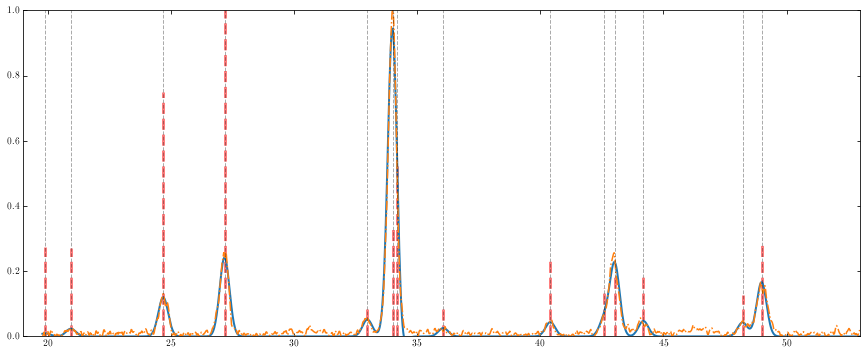

In [18]:
g = xrd_gn[0]
s = xrd_spectra[0]

for _ in range(64):
    g.calibration(alpha=1)

figure(figsize=(15,6))

vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)


xlim(19,53)
ylim(0,1)

[-1253.77514568    52.82535312  1926.68878823]
[-1232.46046394    52.22988911  1934.42238629]
[-1235.41190183    52.22988898  1940.58714901]
[-1236.05322303    52.29587069  1936.68500313]
[-1238.33214179    52.34865189  1935.71551412]
[-1209.08103489    51.52572151  1949.4408658 ]
[-1213.66395836    51.60591811  1948.72712254]
[-1189.47035835    50.84795372  1966.30375454]
[-1202.18522619    51.21818844  1958.2636507 ]


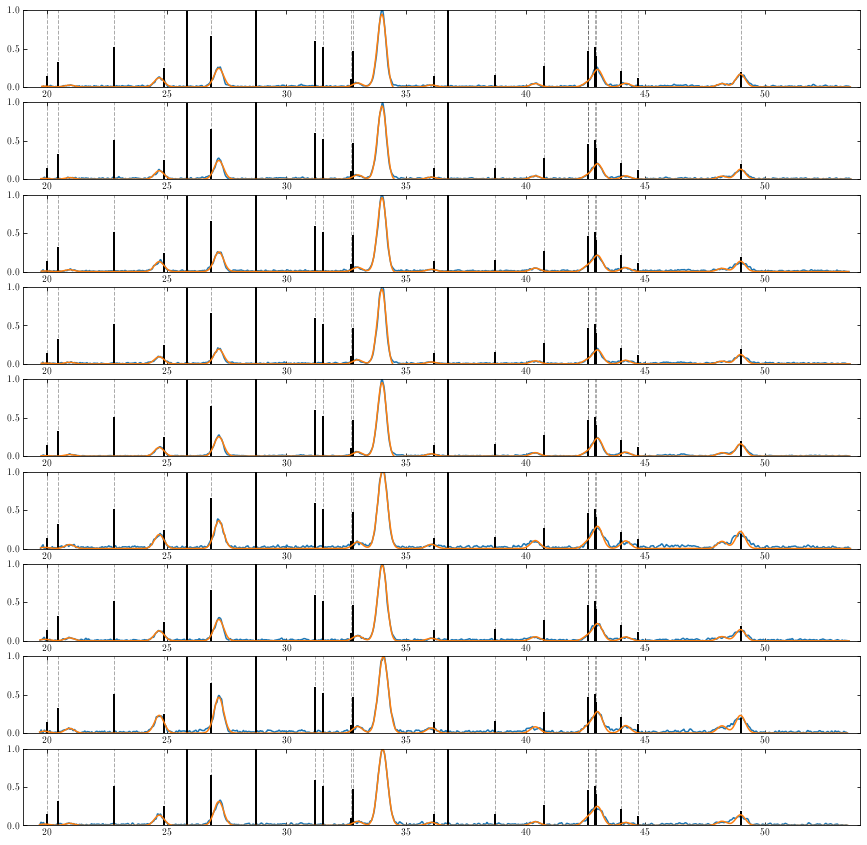

In [20]:
%matplotlib inline
fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))

for i,(spectra,gn) in enumerate(zip(xrd_spectra,xrd_gn)):
    
    for _ in range(16):
        gn.calibration(alpha=1)
    print(gn.spectra.opt)
    
    ax[i].plot(spectra.theta,spectra.intensity)
    
    x,y = cnb_hcs.get_theta(max_theta = 53,min_intensity=0.1)
    ax[i].vlines(x,0,y,'k',lw=2)
    ax[i].vlines(x,0,1.0,'k',lw=1,ls='--',alpha=0.33)
        
    ax[i].plot(gn.theta,gn.z)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

[-1253.77514568    52.82535312  1926.68878823] [-1214.71937795    51.66346478  1952.71389334]
[-1232.46046394    52.22988911  1934.42238629] [-1214.71937795    51.66346478  1952.71389334]
[-1235.41190183    52.22988898  1940.58714901] [-1214.71937795    51.66346478  1952.71389334]
[-1236.05322303    52.29587069  1936.68500313] [-1214.71937795    51.66346478  1952.71389334]
[-1238.33214179    52.34865189  1935.71551412] [-1214.71937795    51.66346478  1952.71389334]
[-1209.08103489    51.52572151  1949.4408658 ] [-1214.71937795    51.66346478  1952.71389334]
[-1213.66395836    51.60591811  1948.72712254] [-1214.71937795    51.66346478  1952.71389334]
[-1189.47035835    50.84795372  1966.30375454] [-1214.71937795    51.66346478  1952.71389334]
[-1202.18522619    51.21818844  1958.2636507 ] [-1214.71937795    51.66346478  1952.71389334]


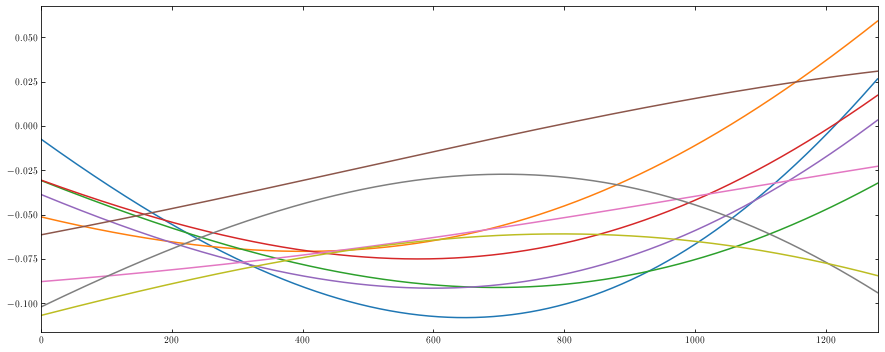

In [21]:
#fig,ax = subplots(len(xrd_spectra),1,figsize = (15,15))
figure(figsize=(15,6))

x = arange(0,1280)
for i,gn in enumerate(xrd_gn):
    opt = gn.spectra.opt
    opt_file = gn.spectra.opt_file
    print(opt,opt_file)
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)
